In [6]:
!mamba create -y -n ulmo ulmo shapely geopandas pyarrow folium ipykernel


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.22.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['ulmo', 'shapely', 'geopandas', 'pyarrow', 'folium', 'ipykernel']

conda-forge/linux-64           

In [1]:
#!conda activate ulmo

In [3]:
!pip install pystac
!pip install pystac_client
!pip install stackstac
!pip install hvplot
!pip install dask distributed
!pip install rioxarray
!pip install contextily
!pip install planetary_computer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 5.3 MB/s eta 0:00:00
  Using cached pystac_client-0.6.0-py3-none-any.whl (30 kB)
  Using cached stackstac-0.4.3-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.2 MB/s eta 0:00:00a 0:00:01
  Using cached xarray-2023.2.0-py3-none-any.whl (975 kB)
  Using cached rasterio-1.3.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (20.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 14.6 MB/s eta 0:00:00
  Using cached partd-1.3.0-py3-none-any.whl (18 kB)
  Using cached PyYAML-6.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (661 kB)
  Using cached toolz-0.12.0-py3-none-any.whl (55 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl (4.4 kB)
  Using cached hvplot

In [4]:
import ulmo
import sys
sys.path.append('../../../sar_snowmelt_timing')
import s1_rtc_bs_utils
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd

In [5]:
#### CODE FOR DEVELOPMENT-- THIS RELOADS s1_rtc_bs_utils MODULE
#sys.modules.pop('s1_rtc_bs_utils')
#import s1_rtc_bs_utils

In [6]:
name = 'Mt. St. Helens (46.19N)'
geojson = 'shapefiles/MSH.geojson'     
collection = '../../../input/sentinel1-rtc-aws/mycollection_helens.json'        

In [7]:
bbox_gdf = gpd.read_file(geojson)
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac(bbox_gdf,start_time='2019-12-01',end_time='2020-01-01',orbit_direction='all',polarization='gamma0_vv',collection=collection)
ts_ds = ts_ds.compute()
ts_ds = ts_ds.dropna('time',how='all')

In [8]:
lava_flows = gpd.read_file('shapefiles/Lava_Flows.shp').to_crs(ts_ds.crs)
lahars = gpd.read_file('shapefiles/Lahar_deposits.shp').to_crs(ts_ds.crs)
pyroclastic = gpd.read_file('shapefiles/PFdeposits.shp').to_crs(ts_ds.crs)

In [9]:
all_geoms = lava_flows.geometry.append(lahars.geometry)
all_geoms = all_geoms.geometry.append(pyroclastic.geometry)

/srv/conda/envs/ulmo/lib/python3.9/site-packages/geopandas/geoseries.py:622: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = getattr(super(), mtd)(*args, **kwargs)


In [10]:
rgb=s1_rtc_bs_utils.get_s2_rgb(ts_ds,cloud_cover_threshold=100)
new_rgb = np.clip(rgb/np.amax(rgb),0,1)

In [11]:
ts_ds = ts_ds.rio.clip(lava_flows.geometry,lava_flows.crs,drop=True,invert=False)

In [12]:
sites_gdf = s1_rtc_bs_utils.find_closest_snotel(ts_ds.rio.clip(all_geoms.geometry,all_geoms.crs,drop=True,invert=False)) 

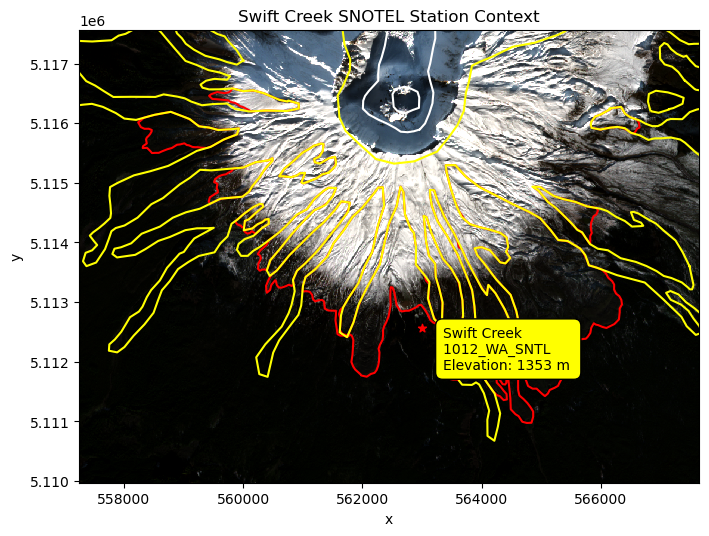

In [13]:
f,ax=plt.subplots(figsize=(8,8))

sites_gdf = s1_rtc_bs_utils.find_closest_snotel(ts_ds)
sites_gdf[sites_gdf['distance_km']==sites_gdf['distance_km'].min()].plot(ax=ax,color='red',marker='*')
    
for x, y, label1, label2, label3, label4 in zip(sites_gdf.geometry.x, sites_gdf.geometry.y, sites_gdf.name, sites_gdf.code, sites_gdf.distance_km, sites_gdf.elevation_m):
    ax.annotate(f'{label1} \n{label2} \nElevation: {label4:.0f} m ', xy=(x, y), xytext=(15, -30), textcoords="offset points", fontsize=10,bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))
    break
        
minx, miny, maxx, maxy = ts_ds.rio.bounds()
distance_cutoff=1
    
new_rgb.isel(time=1).plot.imshow(ax=ax,rgb='band',alpha=1,robust=True)
#sites_gdf.plot(ax=ax,marker='*',color='red',markersize=50)
lava_flows.geometry.boundary.plot(ax=ax,color='red',label='Lava Flows')
lahars.geometry.boundary.plot(ax=ax,color='yellow',label='Lahars')
pyroclastic.geometry.boundary.plot(ax=ax,color='white',label='Pyroclastic Density Currents')
    
ax.set_xlim([minx-1000*distance_cutoff,maxx+1000*distance_cutoff])
ax.set_ylim([miny-1000*distance_cutoff,maxy+1000*distance_cutoff])
    
    #ctx.add_basemap(ax=ax[0], crs=ts_ds.rio.crs, source=ctx.providers.Stamen.Terrain)
ax.set_title('Swift Creek SNOTEL Station Context')
f.savefig('figures/msh_snotel_context.png',dpi=300)

In [14]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

def snotel_fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date='1950-10-01', end_date=today):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

SNOTEL:1012_WA_SNTL SNOTEL:PRCPSA_D 2019-11-01 2020-02-01
SNOTEL:1012_WA_SNTL SNOTEL:TAVG_D 2019-11-01 2020-02-01


/tmp/ipykernel_1810/4159990233.py:21: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  temp_precip_gdf.set_axis(['Temperature','Precip'],axis=1,inplace=True)


SNOTEL:1012_WA_SNTL SNOTEL:SNWD_D 2019-11-01 2020-02-01
SNOTEL:1012_WA_SNTL SNOTEL:WTEQ_D 2019-11-01 2020-02-01


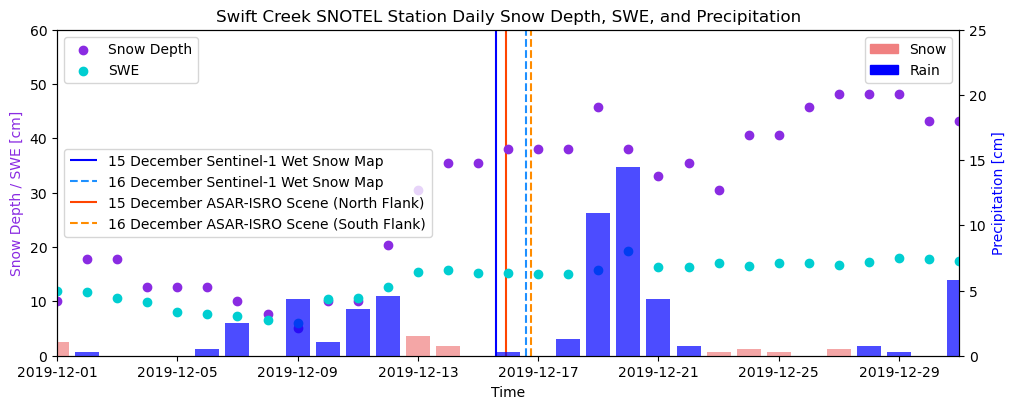

In [40]:
f,ax=plt.subplots(figsize=(10,4))

start_date = '2019-12-01'
end_date = '2019-12-31'


precip_ax = ax.twinx()


#snotel_precip = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:PRCPSA_D',distance_cutoff=30,closest=True,start_date='2019-11-01', end_date='2020-02-01')
#snotel_temp = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:TAVG_D',distance_cutoff=30,closest=True,start_date='2019-11-01', end_date='2020-02-01')

snotel_precip = snotel_fetch('SNOTEL:1012_WA_SNTL',variablecode='SNOTEL:PRCPSA_D',start_date='2019-11-01', end_date='2020-02-01')['value']
snotel_temp = snotel_fetch('SNOTEL:1012_WA_SNTL',variablecode='SNOTEL:TAVG_D',start_date='2019-11-01', end_date='2020-02-01')['value']




snotel_temp=(snotel_temp-32)/1.8
temp_precip_gdf = pd.concat([snotel_temp,snotel_precip],axis=1,join='inner')
temp_precip_gdf.set_axis(['Temperature','Precip'],axis=1,inplace=True)
conditions = [(temp_precip_gdf['Temperature'] <=0),(temp_precip_gdf['Temperature'] > 0)]
values = ['lightcoral', 'blue']
temp_precip_gdf['bar_color'] = np.select(conditions, values)
    
    
precip_plot = precip_ax.bar(temp_precip_gdf.index,2.54*temp_precip_gdf.iloc[:,1],color=temp_precip_gdf['bar_color'],alpha=0.7,label='Precipitation')

#snotel_snwd = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:SNWD_D',distance_cutoff=30,closest=True,start_date='2019-11-01', end_date='2020-02-01')
snotel_snwd = snotel_fetch('SNOTEL:1012_WA_SNTL',variablecode='SNOTEL:SNWD_D',start_date='2019-11-01', end_date='2020-02-01')['value']

snwd_plot = ax.scatter(snotel_snwd.index,2.54*snotel_snwd.iloc[:],color='blueviolet',alpha=1,label='Snow Depth',zorder=5)
    
#snotel_swe = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:WTEQ_D',distance_cutoff=30,closest=True,start_date='2019-11-01', end_date='2020-02-01')
snotel_swe = snotel_fetch('SNOTEL:1012_WA_SNTL',variablecode='SNOTEL:WTEQ_D',start_date='2019-11-01', end_date='2020-02-01')['value']
swe_plot = ax.scatter(snotel_swe.index,2.54*snotel_swe.iloc[:],color='darkturquoise',alpha=1,label='SWE',zorder=5)
    
lns = [snwd_plot,swe_plot,precip_plot]
extra_legend = ax.legend(handles=lns,loc='upper center')
ax.legend(loc='upper left')

ax.yaxis.label.set_color('blueviolet')
precip_ax.yaxis.label.set_color('blue')
    
ax.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   



colors = {'Snow':'lightcoral', 'Rain':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
precip_ax.legend(handles, labels, loc='upper right')

precip_ax.set_ylim([0,25])
site_name = sites_gdf[sites_gdf['distance_km']==sites_gdf['distance_km'].min()]['code'].values[0]
ax.set_title(f'Swift Creek SNOTEL Station Daily Snow Depth, SWE, and Precipitation')

precip_ax.set_ylim([0,25])
ax.set_ylim([0,60])



s11 = ax.vlines(pd.to_datetime('2019-12-15 14:22:24UTC'),label='15 December Sentinel-1 Wet Snow Map',ymin=0,ymax=60,color='blue')
s12 = ax.vlines(pd.to_datetime('2019-12-16 14:13:07UTC'),label='16 December Sentinel-1 Wet Snow Map',ymin=0,ymax=60,color='dodgerblue',linestyles='dashed')

ai1 = ax.vlines(pd.to_datetime('2019-12-15T22:34:15'),label='15 December ASAR-ISRO Scene (North Flank)',ymin=0,ymax=60,color='orangered')
ai2 = ax.vlines(pd.to_datetime('2019-12-16T18:01:46'),label='16 December ASAR-ISRO Scene (South Flank)',ymin=0,ymax=60,color='darkorange',linestyles='dashed')

lns2 = [s11,s12,ai1,ai2]
new_legend_ax = ax.twinx()
new_legend_ax.axis('off')
extra_legend = new_legend_ax.legend(handles=lns2,loc='center left')




plt.tight_layout()


ax.set_xlabel("Time")
ax.set_ylabel("Snow Depth / SWE [cm]")
precip_ax.set_ylabel("Precipitation [cm]")
f.savefig('figures/snwd_swe_precip_daily.png',dpi=300)

SNOTEL:1012_WA_SNTL SNOTEL:TOBS_H 2019-11-01 2020-02-01
SNOTEL:1012_WA_SNTL SNOTEL:SNWD_H 2019-11-01 2020-02-01
SNOTEL:1012_WA_SNTL SNOTEL:WTEQ_H 2019-11-01 2020-02-01


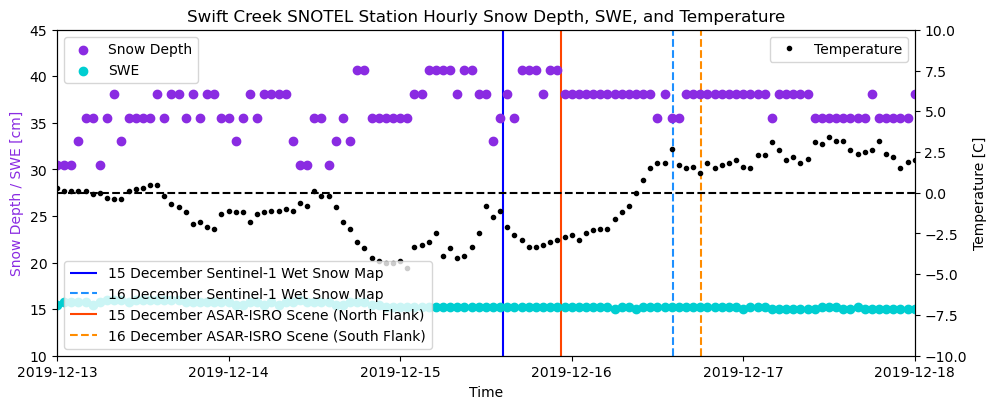

In [37]:
f,ax=plt.subplots(figsize=(10,4))

start_date = '2019-12-13'
end_date = '2019-12-18'


temp_ax = ax.twinx()
temp_ax.set_ylabel("Temperature [C]")

#snotel_precip = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:PRCPSA_D',distance_cutoff=30,closest=True,start_date='2019-11-01', end_date='2020-02-01')
#snotel_temp = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:TAVG_D',distance_cutoff=30,closest=True,start_date='2019-11-01', end_date='2020-02-01')

snotel_temp = snotel_fetch('SNOTEL:1012_WA_SNTL',variablecode='SNOTEL:TOBS_H',start_date='2019-11-01', end_date='2020-02-01')['value']




snotel_temp=(snotel_temp-32)/1.8

#snotel_snwd = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:SNWD_D',distance_cutoff=30,closest=True,start_date='2019-11-01', end_date='2020-02-01')
snotel_snwd = snotel_fetch('SNOTEL:1012_WA_SNTL',variablecode='SNOTEL:SNWD_H',start_date='2019-11-01', end_date='2020-02-01')['value']

snwd_plot = ax.scatter(snotel_snwd.index,2.54*snotel_snwd.iloc[:],color='blueviolet',alpha=1,label='Snow Depth',zorder=5)
    
#snotel_swe = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:WTEQ_D',distance_cutoff=30,closest=True,start_date='2019-11-01', end_date='2020-02-01')
snotel_swe = snotel_fetch('SNOTEL:1012_WA_SNTL',variablecode='SNOTEL:WTEQ_H',start_date='2019-11-01', end_date='2020-02-01')['value']
swe_plot = ax.scatter(snotel_swe.index,2.54*snotel_swe.iloc[:],color='darkturquoise',alpha=1,label='SWE',zorder=5)
    
lns = [snwd_plot,swe_plot,precip_plot]
extra_legend = ax.legend(handles=lns,loc='upper center')
ax.legend(loc='upper left')

    
snotel_temp.plot(ax=temp_ax,label='Temperature',color='black',linewidth=0,marker='.')
temp_ax.set_ylim([-10,10])
temp_ax.legend(['Temperature'],loc='upper right')

temp_ax.hlines(y=0,xmin=datetime.strptime(start_date,'%Y-%m-%d'),xmax=datetime.strptime(end_date,'%Y-%m-%d'),color='black',linestyle='--')


ax.yaxis.label.set_color('blueviolet')
    
ax.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   



colors = {'Snow':'lightcoral', 'Rain':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
precip_ax.legend(handles, labels, loc='upper right')

site_name = sites_gdf[sites_gdf['distance_km']==sites_gdf['distance_km'].min()]['code'].values[0]
ax.set_title(f'Swift Creek SNOTEL Station Hourly Snow Depth, SWE, and Temperature')

ax.set_ylim([10,45])



s11 = ax.vlines(pd.to_datetime('2019-12-15 14:22:24UTC'),label='15 December Sentinel-1 Wet Snow Map',ymin=10,ymax=45,color='blue')
s12 = ax.vlines(pd.to_datetime('2019-12-16 14:13:07UTC'),label='16 December Sentinel-1 Wet Snow Map',ymin=10,ymax=45,color='dodgerblue',linestyles='dashed')

ai1 = ax.vlines(pd.to_datetime('2019-12-15T22:34:15'),label='15 December ASAR-ISRO Scene (North Flank)',ymin=10,ymax=45,color='orangered')
ai2 = ax.vlines(pd.to_datetime('2019-12-16T18:01:46'),label='16 December ASAR-ISRO Scene (South Flank)',ymin=10,ymax=45,color='darkorange',linestyles='dashed')

lns2 = [s11,s12,ai1,ai2]
new_legend_ax = ax.twinx()
new_legend_ax.axis('off')
extra_legend = new_legend_ax.legend(handles=lns2,loc='lower left')


plt.tight_layout()


ax.set_xlabel("Time")
ax.set_ylabel("Snow Depth / SWE [cm]")
f.savefig('figures/snwd_swe_temp_hourly.png',dpi=300)

In [17]:
# 2019-12-15 14:22:24UTC Binary wet snowmap
# 2019-12-16 14:13:07UTC binary wet snow map
#ASAR-ISRO (North) 2019-12-15 2:34pm T22:34:15
# ASAR-ISRO (South) 2019-12-16 10:01am T18:01:46

In [41]:
#pd.to_datetime('2019-12-15 14:22:24UTC')
#pd.to_datetime('2019-12-16 14:13:07UTC')

#pd.to_datetime('2019-12-15T22:34:15')
#pd.to_datetime('2019-12-16T18:01:46')